In [1]:
import math
import string

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

In [2]:
fc = pd.read_csv('/Users/lydia/Documents/psych532-ToM-project/neuroimaging_analysis/extension/fc_vals.csv').T

In [3]:
fc.head()

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
Unnamed: 0,0.0,1.000000,2.000000,3.000000,4.000000,5.0,6.000000,7.0,8.0,9.0,...,9990.000000,9991.0,9992.000000,9993.0,9994.0,9995.0,9996.0,9997.000000,9998.000000,9999.0
sub-pixar001,0.0,0.148457,0.169583,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,-0.029880,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.098441,0.0
sub-pixar003,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.037535,0.0,0.040662,0.0,0.0,0.0,0.0,-0.011242,0.020721,0.0
sub-pixar005,0.0,0.155015,0.167935,0.000000,-0.040975,0.0,0.000000,0.0,0.0,0.0,...,0.014121,0.0,0.024896,0.0,0.0,0.0,0.0,0.000000,0.203274,0.0
sub-pixar006,0.0,0.068194,0.226563,0.141008,0.000000,0.0,-0.220001,0.0,0.0,0.0,...,0.000000,0.0,-0.015935,0.0,0.0,0.0,0.0,0.000000,0.115414,0.0


In [4]:
participants_df = pd.read_csv('participants.tsv', sep = '\t')

In [5]:
participants_df.head()

,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness,ToM Booklet-Matched,ToM Booklet-Matched-NOFB,FB_Composite,FB_Group,WPPSI BD raw,WPPSI BD scaled,KBIT_raw,KBIT_standard,DCCS Summary,Scanlog: Scanner,Scanlog: Coil,Scanlog: Voxel slize,Scanlog: Slice Gap
0,sub-pixar001,4.774812,4yo,child,M,R,0.80,0.736842,6.0,pass,22.0,13.0,NaN,NaN,3.0,3T1,7-8yo 32ch,3mm iso,0.1
1,sub-pixar002,4.856947,4yo,child,F,R,0.72,0.736842,4.0,inc,18.0,9.0,NaN,NaN,2.0,3T1,7-8yo 32ch,3mm iso,0.1
2,sub-pixar003,4.153320,4yo,child,F,R,0.44,0.421053,3.0,inc,15.0,9.0,NaN,NaN,3.0,3T1,7-8yo 32ch,3mm iso,0.1
3,sub-pixar004,4.473648,4yo,child,F,R,0.64,0.736842,2.0,fail,17.0,10.0,NaN,NaN,3.0,3T1,7-8yo 32ch,3mm iso,0.2
4,sub-pixar005,4.837782,4yo,child,F,R,0.60,0.578947,4.0,inc,13.0,5.0,NaN,NaN,2.0,3T1,7-8yo 32ch,3mm iso,0.2


In [6]:
df_one = pd.get_dummies(participants_df['Gender'])
df_two = pd.concat((df_one, participants_df), axis=1)
df_two = df_two.drop(["Gender"], axis=1)
df_two = df_two.drop(["M"], axis=1)
participants_df = df_two.rename(columns={"F": "Gender"}) # Male =0 and Female =1

In [7]:
fc['Gender'] = None
for index, value in fc.iloc[:, 0].items():
    if index in participants_df['participant_id'].values:
        gender = participants_df.loc[participants_df['participant_id'] == index, 'Gender'].values[0]
        fc.at[index, 'Gender'] = gender

In [8]:
fc.drop(index=fc.index[0], axis=0, inplace=True)
fc.head()

,0,1,2,3,4,5,6,7,8,9,...,9991,9992,9993,9994,9995,9996,9997,9998,9999,Gender
sub-pixar001,0.0,0.148457,0.169583,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.098441,0.0,0
sub-pixar003,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.040662,0.0,0.0,0.000000,0.0,-0.011242,0.020721,0.0,1
sub-pixar005,0.0,0.155015,0.167935,0.000000,-0.040975,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.024896,0.0,0.0,0.000000,0.0,0.000000,0.203274,0.0,1
sub-pixar006,0.0,0.068194,0.226563,0.141008,0.000000,0.0,-0.220001,0.0,0.0,0.000000,...,0.000000,-0.015935,0.0,0.0,0.000000,0.0,0.000000,0.115414,0.0,1
sub-pixar007,0.0,0.020132,0.349057,0.000000,0.000000,0.0,0.000000,0.0,0.0,-0.140694,...,-0.028638,0.061480,0.0,0.0,0.008568,0.0,0.000000,0.082131,0.0,0


In [9]:
train_data, test_and_validation_data = train_test_split(fc, test_size=0.2)
validation_data, test_data = train_test_split(test_and_validation_data, test_size=0.5)

In [10]:
scaler = StandardScaler()
scaler.fit(train_data)
scaler.transform(train_data)
scaler.transform(validation_data)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


array([[ 0.00000000e+00,  3.59951030e+00,  4.49483072e-01, ...,
        -8.01462359e-01,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00, -4.25923003e-01,  6.81069261e-02, ...,
        -1.08555495e+00,  0.00000000e+00, -1.00000000e+00],
       [ 0.00000000e+00,  1.39505731e+00,  2.01030456e-02, ...,
         3.04366915e-01,  0.00000000e+00, -1.00000000e+00],
       ...,
       [ 0.00000000e+00, -4.25923003e-01, -1.22142194e+00, ...,
        -1.18217445e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  1.50381545e-03, -1.92244581e-01, ...,
        -1.18217445e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00, -4.25923003e-01, -1.22142194e+00, ...,
        -1.18217445e+00,  0.00000000e+00,  1.00000000e+00]])

In [11]:
logistic_model = LogisticRegression(penalty='l2', C=1e23) #C=1/Lambda

In [12]:
logistic_model.fit(train_data.iloc[:,:-1], train_data['Gender'].astype(int))

LogisticRegression(C=1e+23)

In [13]:
#coefficients
coefficients = logistic_model.coef_
print('Smallest coefficient', coefficients.min())
print('Largest coefficient:', coefficients.max())

Smallest coefficient -2.639278314226651
Largest coefficient: 2.2394308115206


In [14]:
#predict the probability of the target
logistic_model.predict_proba(validation_data.iloc[:,:-1])

array([[9.95789521e-01, 4.21047866e-03],
       [9.36910860e-03, 9.90630891e-01],
       [9.98941397e-01, 1.05860300e-03],
       [1.66578146e-01, 8.33421854e-01],
       [8.19067606e-04, 9.99180932e-01],
       [9.54233852e-03, 9.90457661e-01],
       [2.75129632e-01, 7.24870368e-01],
       [8.80183445e-04, 9.99119817e-01],
       [2.81653521e-02, 9.71834648e-01],
       [3.98297552e-02, 9.60170245e-01]])

In [15]:
#predict labels
logistic_model.predict(validation_data.iloc[:,:-1])

array([0, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [16]:
#find the validation accuracy
logistic_model_val_accuracy = accuracy_score(validation_data['Gender'].astype(int), logistic_model.predict(validation_data.iloc[:,:-1]))

In [17]:
logistic_model_val_accuracy

0.7

In [18]:
# create a confusion matrix
def plot_confusion_matrix(tp, fp, fn, tn):
    """
    Plots a confusion matrix using the values 
       tp - True Positive
       fp - False Positive
       fn - False Negative
       tn - True Negative
    """
    data = np.matrix([[tp, fp], [fn, tn]])

    heatmap = sns.heatmap(data,annot=True,xticklabels=['Actual Pos', 'Actual Neg']
              ,yticklabels=['Pred. Pos', 'Pred. Neg']) 
    
    fig = heatmap.get_figure()
    fig.savefig("confusion_matrix.png")

from sklearn.metrics import confusion_matrix
tp = confusion_matrix(validation_data['Gender'].astype(int), logistic_model.predict(validation_data.iloc[:, :-1]))[1,1]
fp = confusion_matrix(validation_data['Gender'].astype(int), logistic_model.predict(validation_data.iloc[:, :-1]))[0,1]
tn = confusion_matrix(validation_data['Gender'].astype(int), logistic_model.predict(validation_data.iloc[:, :-1]))[0,0]
fn = confusion_matrix(validation_data['Gender'].astype(int), logistic_model.predict(validation_data.iloc[:, :-1]))[1,0]

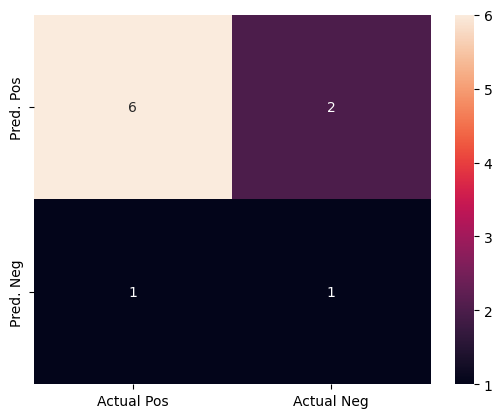

In [19]:
plot_confusion_matrix(tp=tp, fp=fp, tn=tn, fn=fn)

In [20]:
# set up different regularization penalties to try
l2_penalties = [0.01, 1, 4, 10, 1e2, 1e3, 1e5]
l2_penalty_names = [f'coefficients [L2={l2_penalty:.0e}]' 
                    for l2_penalty in l2_penalties]

coef_table = pd.DataFrame(columns=['features'] + l2_penalty_names)
coef_table['features'] = np.arange(10000)

accuracy_data = []

for l2_penalty, l2_penalty_column_name in zip(l2_penalties, l2_penalty_names):
     model = LogisticRegression(penalty='l2', C=1/l2_penalty, random_state=0, fit_intercept=False)
     model.fit(train_data.iloc[:,:-1], train_data['Gender'].astype(int))
     coef_table[l2_penalty_column_name] = model.coef_[0]

     train_accuracy = accuracy_score(train_data['Gender'].astype(int), model.predict(train_data.iloc[:,:-1]))
     validation_accuracy = accuracy_score(validation_data['Gender'].astype(int), model.predict(validation_data.iloc[:,:-1]))
     accuracy_data.append({'l2_penalty': l2_penalty, 'train_accuracy': train_accuracy, 'validation_accuracy':validation_accuracy})

accuracies_table = pd.DataFrame(accuracy_data)    

In [21]:
coef_table

,features,coefficients [L2=1e-02],coefficients [L2=1e+00],coefficients [L2=4e+00],coefficients [L2=1e+01],coefficients [L2=1e+02],coefficients [L2=1e+03],coefficients [L2=1e+05]
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
1,1,-0.130056,-0.046274,-0.025591,-0.014952,-0.002330,-0.000248,-2.482394e-06
2,2,-0.520694,-0.180374,-0.095939,-0.053640,-0.007548,-0.000778,-7.713868e-06
3,3,0.040892,0.015022,0.008349,0.004751,0.000617,0.000063,6.296676e-07
4,4,0.063055,0.022756,0.012726,0.007582,0.001255,0.000137,1.378836e-06
...,...,...,...,...,...,...,...,...
9995,9995,-0.046345,-0.014567,-0.006712,-0.002988,-0.000118,-0.000002,-2.343345e-09
9996,9996,-0.241725,-0.089697,-0.050500,-0.029479,-0.004328,-0.000455,-4.561261e-06
9997,9997,-0.085655,-0.032234,-0.018189,-0.010535,-0.001473,-0.000152,-1.515225e-06
9998,9998,-0.014149,-0.007666,-0.005505,-0.003874,-0.000760,-0.000077,-7.254077e-07


In [22]:
accuracies_table

,l2_penalty,train_accuracy,validation_accuracy
0,0.01,1.000000,0.7
1,1.00,1.000000,0.7
2,4.00,1.000000,0.7
3,10.00,1.000000,0.7
4,100.00,1.000000,0.7
5,1000.00,0.974359,0.7
6,100000.00,0.910256,0.7


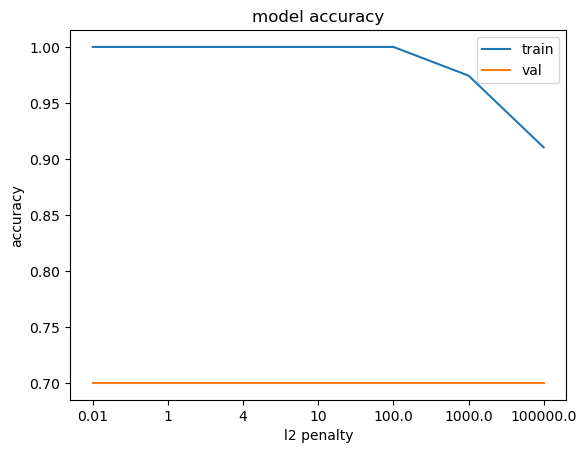

In [23]:
plt.plot(accuracies_table['train_accuracy'])
plt.plot(accuracies_table['validation_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('l2 penalty')
plt.xticks(range(len(l2_penalties)), l2_penalties)
plt.legend(['train', 'val'], loc='upper right')
plt.savefig("model_accuracy.png")
plt.show()


In [24]:
positive_features = coef_table.loc[coef_table['coefficients [L2=4e+00]'].nlargest(5).index, 'features']
negative_features = coef_table.loc[coef_table['coefficients [L2=4e+00]'].nsmallest(5).index, 'features']

In [25]:
print(positive_features)
print(negative_features)

5101    5101
6768    6768
8426    8426
8283    8283
5708    5708
Name: features, dtype: int64
3179    3179
5809    5809
2922    2922
7931    7931
4244    4244
Name: features, dtype: int64
